In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split

import string
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from scipy.stats import skew,boxcox  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from vecstack import stacking

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
pd.set_option('display.max_columns', 100)


# 1 Data Loading

In [315]:
raw_analysis = pd.read_csv('./analysisData.csv')
raw_scoring = pd.read_csv('./scoringData.csv')

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = raw_analysis.copy()
df_test = raw_scoring.copy()
df_all = concat_df(df_train, df_test)

print('The shape of training set: {}'.format(df_train.shape))
print('The shape of test set: {}'.format(df_test.shape))
print('The shape of ALL set: {}'.format(df_all.shape))

The shape of training set: (36839, 91)
The shape of test set: (9210, 90)
The shape of ALL set: (46049, 91)


In [316]:
y = df_train.loc[:,['price']]

In [317]:
y.shape

(36839, 1)

# 2 Feature Selection 

In [318]:
columns_keep = [
                
                'accommodates','bathrooms','bedrooms','beds','bed_type',
                'cancellation_policy','cleaning_fee','extra_people','host_response_time',
                'host_has_profile_pic','guests_included',
                'review_scores_value', 'reviews_per_month', 'room_type','property_type',
                'security_deposit',
    
                'amenities', 'host_verifications','house_rules','interaction',
                'neighborhood_overview', 
                'summary','zipcode',
    
                'availability_30', 'availability_365','availability_60','availability_90',
                'calculated_host_listings_count', 'host_total_listings_count',
                'number_of_reviews','number_of_reviews_ltm'
               ]

X_all = df_all.loc[:, columns_keep]

In [319]:
type(X_all.amenities[123])

str

In [320]:

X_all.summary.isna().sum()

1768

# 3 Data Cleaning

In [321]:
X_all.beds = X_all.beds.fillna(X_all.beds.median())
X_all.reviews_per_month = X_all.reviews_per_month.fillna(X_all.reviews_per_month.median())

X_all['cleaning_fee_missing'] = X_all.cleaning_fee.isna()
X_all.cleaning_fee = X_all.cleaning_fee.fillna(X_all.cleaning_fee.median())

X_all.host_has_profile_pic = X_all.host_has_profile_pic.fillna(0)

X_all['security_deposit_missing']  = X_all.security_deposit.isna()
X_all.security_deposit = X_all.groupby(['beds','room_type'])['security_deposit'].apply(lambda x:x.fillna(x.median()))
X_all.security_deposit = X_all.security_deposit.fillna(X_all.security_deposit.median())

X_all['host_response_time_missing'] = X_all.host_response_time.isna()
X_all.host_response_time = X_all.host_response_time.fillna('missing')

X_all.host_total_listings_count = X_all.host_total_listings_count.fillna(X_all.host_total_listings_count.median())

X_all.house_rules = X_all.house_rules.fillna('missing')
X_all.interaction = X_all.interaction.fillna('missing')
X_all.neighborhood_overview = X_all.neighborhood_overview.fillna('missing')
X_all.number_of_reviews = X_all.number_of_reviews.fillna('missing')
X_all.summary = X_all.summary.fillna('missing')
X_all.amenities = X_all.amenities.fillna('missing')

In [322]:
def int_transform(x):
    try: 
        if type(x)==str:
            value = int(x[0:5])
        else:
            value = int(x)
    except:
        value = 0
    return value

X_all.zipcode = X_all.zipcode.apply(int_transform)
X_all['zipcode_missing'] = (X_all.zipcode==0)

In [323]:
X_all.isnull().sum().sum()

0

# 4 Feature Engineering

#### 4.1 Skewness 

In [324]:
# #continuous_features = ['cleaning_fee','reviews_per_month','security_deposit']
# numerical_features = [
#                         'extra_people','bathrooms','guests_included',
#                         'beds','accommodates','bedrooms','cleaning_fee',
#                         'reviews_per_month',
#                         'review_scores_value',
#                         'availability_30', 'availability_365','availability_60','availability_90',
#                         'calculated_host_listings_count', 'host_total_listings_count',
#                         'number_of_reviews','number_of_reviews_ltm'
#                      ]
# numerical_features
# skewness_features = X_all.loc[:,numerical_features].skew().sort_values(ascending=False)
# skewness_features


In [325]:
# from scipy.stats import boxcox
# for i in skewness_features.index:
#         df_tmp = X_all[i].apply(lambda x:x+0.00001)
#         try:
#             X_all[i],lmbda = boxcox(df_tmp,lmbda=None)
#         except:
#             print(i)

In [326]:
# skewness_features = X_all.loc[:,numerical_features].skew().sort_values(ascending=False)
# skewness_features

#### 4.2 Text Processing

In [327]:
test_features =['amenities', 'host_verifications','house_rules','interaction',
                'neighborhood_overview', 
                'summary'
               ]
for feat in test_features:
    X_all[feat] = X_all[feat].apply(lambda x: len(x))
X_all['summary'].head(10)

0    314
1    152
2    347
3    510
4     50
5    155
6    337
7    402
8    512
9    403
Name: summary, dtype: int64

#### 4.3 Label Encoding

In [328]:



cate_features = [
                 'bed_type','cancellation_policy','host_response_time',
                 'room_type', 'property_type', 'host_has_profile_pic','zipcode'
                ]
le = LabelEncoder()
for feat in cate_features:
    try:
        X_all[feat] = le.fit_transform(X_all[feat].astype(str))
    except: 
        print(feat)
    

In [329]:
X_all.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,zipcode,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
12332,2,1.0,1,1.0,4,3,100.0,25,3,2,1,10,0.29,1,1,0.0,415,67,28,56,458,374,17,17,352,47,77,3,3.0,1,1,False,False,False,False
11638,4,1.0,2,2.0,4,0,35.0,20,4,2,2,8,0.31,0,20,200.0,245,78,1013,306,967,185,183,23,358,53,83,3,3.0,10,6,False,True,False,False
35407,2,1.0,1,2.0,4,3,30.0,25,2,2,1,9,0.56,0,1,100.0,149,55,7,7,7,7,130,13,310,23,53,1,1.0,40,1,False,False,False,False


#### 4.4 OneHot and Not OneHot

In [330]:
X_all1 = X_all.copy()
X_all2 = X_all.copy()

onehot_features = [
                    'bed_type', 'cancellation_policy','host_response_time',
                    'room_type', 'property_type',
                    'host_has_profile_pic','zipcode'
                  ]

for feat in onehot_features:
    dummy_col = pd.get_dummies(X_all1[feat], prefix=feat)
    X_all1 = pd.concat([X_all1, dummy_col],axis=1)

X_all1 = X_all1.drop(onehot_features, axis=1)

In [331]:
X_all1.sample(3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4,cancellation_policy_0,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_response_time_4,room_type_0,room_type_1,room_type_2,property_type_0,property_type_1,property_type_2,...,zipcode_145,zipcode_146,zipcode_147,zipcode_148,zipcode_149,zipcode_150,zipcode_151,zipcode_152,zipcode_153,zipcode_154,zipcode_155,zipcode_156,zipcode_157,zipcode_158,zipcode_159,zipcode_160,zipcode_161,zipcode_162,zipcode_163,zipcode_164,zipcode_165,zipcode_166,zipcode_167,zipcode_168,zipcode_169,zipcode_170,zipcode_171,zipcode_172,zipcode_173,zipcode_174,zipcode_175,zipcode_176,zipcode_177,zipcode_178,zipcode_179,zipcode_180,zipcode_181,zipcode_182,zipcode_183,zipcode_184,zipcode_185,zipcode_186,zipcode_187,zipcode_188,zipcode_189,zipcode_190,zipcode_191,zipcode_192,zipcode_193,zipcode_194
29592,10,1.5,3,9.0,185.0,45,2,9,1.07,750.0,713,50,1015,303,720,500,23,141,44,71,1,1.0,47,27,False,False,False,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43398,1,1.0,1,1.0,60.0,0,1,9,0.35,400.0,116,55,7,7,7,7,29,89,59,89,1,1.0,2,2,False,False,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35491,1,1.0,1,1.0,80.0,0,1,6,0.23,100.0,192,96,461,112,177,508,30,270,60,90,1,1.0,1,1,False,True,True,False,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [332]:
# make sure features name unique
X_all2.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,zipcode,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
7679,2,1.0,2,2.0,4,1,35.0,100,1,2,1,10,2.18,0,1,0.0,403,140,7,384,7,479,27,0,0,0,0,1,1.0,64,26,False,False,True,False
38306,3,1.0,1,2.0,4,3,100.0,20,2,2,2,10,0.41,1,1,100.0,340,122,309,184,1028,162,117,30,365,60,90,3,3.0,18,0,False,False,False,False
14960,4,1.5,2,2.0,4,3,120.0,0,3,2,1,7,0.23,0,1,0.0,282,29,7,54,165,446,20,18,314,48,78,6,6.0,2,2,False,False,False,False


#### 4.5 Max-min Scaling

In [333]:
# scaler = MinMaxScaler(feature_range=(0,1))
# X_all1 = pd.DataFrame(data = scaler.fit_transform(X_all1),
#                       columns = X_all1.columns)
# X_all2 = pd.DataFrame(data = scaler.fit_transform(X_all2),
#                       columns = X_all2.columns)
# X_all1.sample(3)

In [334]:
X_all2.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,zipcode,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
1862,3,1.0,1,1.0,4,1,25.0,0,4,2,1,10,2.80,0,1,0.0,255,29,7,73,103,185,100,9,9,9,9,1,1.0,54,27,False,False,False,False
14800,3,1.0,1,1.0,4,0,100.0,0,4,2,1,10,0.68,0,11,0.0,152,80,7,99,884,508,8,0,0,0,0,1,1.0,2,2,False,False,False,False
25172,2,1.0,1,1.0,4,0,50.0,0,4,2,1,10,2.95,1,1,100.0,380,83,42,7,7,298,34,4,12,9,12,1,1.0,13,13,True,True,False,False


In [335]:
print(X_all2.shape)

(46049, 35)


# 5 X, X_test split
##### Now:  X_all -> X + X_test 
##### Later:......... -> (X_train+X_dev) + X_test

In [336]:
X1, X_test1 = X_all1.iloc[0:36839], X_all1.iloc[36839:] 
X2, X_test2 = X_all2.iloc[0:36839], X_all2.iloc[36839:]
print(X1.shape)
print(X_test1.shape)
print(X2.shape)
print(X_test2.shape)

(36839, 279)
(9210, 279)
(36839, 35)
(9210, 35)


In [337]:
X1.head()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4,cancellation_policy_0,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_response_time_4,room_type_0,room_type_1,room_type_2,property_type_0,property_type_1,property_type_2,...,zipcode_145,zipcode_146,zipcode_147,zipcode_148,zipcode_149,zipcode_150,zipcode_151,zipcode_152,zipcode_153,zipcode_154,zipcode_155,zipcode_156,zipcode_157,zipcode_158,zipcode_159,zipcode_160,zipcode_161,zipcode_162,zipcode_163,zipcode_164,zipcode_165,zipcode_166,zipcode_167,zipcode_168,zipcode_169,zipcode_170,zipcode_171,zipcode_172,zipcode_173,zipcode_174,zipcode_175,zipcode_176,zipcode_177,zipcode_178,zipcode_179,zipcode_180,zipcode_181,zipcode_182,zipcode_183,zipcode_184,zipcode_185,zipcode_186,zipcode_187,zipcode_188,zipcode_189,zipcode_190,zipcode_191,zipcode_192,zipcode_193,zipcode_194
0,2,1.5,1,1.0,0.0,0,1,10,1.88,0.0,169,89,7,36,35,314,10,10,10,10,1,1.0,3,3,False,False,True,False,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1.0,2,2.0,10.0,20,1,9,0.21,100.0,268,29,7,38,93,152,20,59,29,59,2,2.0,8,6,False,False,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1.0,1,1.0,50.0,0,1,9,0.36,100.0,119,55,7,50,7,347,0,0,0,0,1,1.0,5,1,True,True,True,False,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1.0,1,1.0,0.0,20,1,9,9.69,0.0,362,60,7,344,353,510,23,358,53,83,1,1.0,31,31,False,False,False,False,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,1.0,1,1.0,10.0,18,1,9,2.62,0.0,313,92,1024,194,7,50,20,70,40,70,1,2.0,57,27,False,False,False,False,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


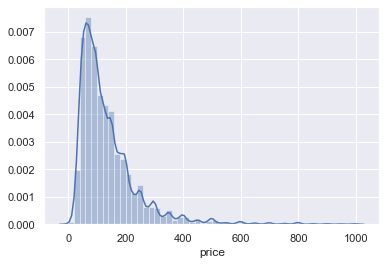

In [338]:
sns.distplot(y.price)

In [394]:
X_train, X_dev, y_train, y_dev = train_test_split(X1, y, train_size = 26000, random_state=22) 

In [395]:
#y.price.counts

In [396]:
# filter = (X1.bathrooms < 5) & (X1.bedrooms <= 7) & (X1.amenities <= 1000) & (y.price < 250)
# X1[filter].shape
filter = (X_train.bathrooms < 5) & (X_train.bedrooms <= 7) & (X_train.amenities <= 1000) & (y_train.price < 250)
X_train[filter].shape

(23031, 279)

In [397]:
y_train[filter].shape

(23031, 1)

# 6 Model Selection
##### train X_train, predict X_dev

#### 6.1 Basic GSCV setting

In [406]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=25)
M_major= LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                      importance_type='split', learning_rate=0.05, max_depth=11,
                      min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                      n_estimators=100, n_jobs=-1, num_leaves=37,
                      objective='regression', random_state=None, reg_alpha=15,
                      reg_lambda=0.0, silent=True, subsample=1.0,
                      subsample_for_bin=200000, subsample_freq=0)
M_minor = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                      importance_type='split', learning_rate=0.05, max_depth=11,
                      min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                      n_estimators=80, n_jobs=-1, num_leaves=37,
                      objective='regression', random_state=None, reg_alpha=15,
                      reg_lambda=0.0, silent=True, subsample=1.0,
                      subsample_for_bin=200000, subsample_freq=0)

M_major.fit(X_train[filter],y_train[filter])
print('train score1: ',sqrt(mean_squared_error(M_major.predict(X_train[filter]), y_train[filter])) )
M_minor.fit(X_train,y_train)
print('train score2: ',sqrt(mean_squared_error(M_minor.predict(X_train), y_train)) )

train score1:  31.1626019199335
train score2:  58.67234722435705


In [ ]:
y_final = []
X_test = X_dev
#(X1.bathrooms < 5) & (X1.bedrooms <= 7) & (X1.amenities <= 1000) & (y.price < 400)
cnt = 0 
# 0~25999, 26000~36838

y_final = M_minor.predict(X_test)

for row in range(0,10839):
    if row %  100 == 0:
        print('iteration:',row//100)
   # row_id = row + 26000 #36839 
    p1 = y_final[row]
    if (X_test.iloc[row].loc['bathrooms'] < 5) and (X_test.iloc[row].loc['bedrooms']<=7) and (X_test.iloc[row].loc['amenities']<=1000) and (p1 < 250):
    #if (X_test.get_value(row_id,'bathrooms') < 5) and (X_test.get_value(row_id,'bedrooms')<=7) and (X_test.get_value(row_id,'amenities')<=1000) and (p1 < 310):
        p2 = M_major.predict(X_test.iloc[[row]])[0]
        y_final[row] = p2
        cnt += 1
print('cnt: ',cnt)
print('train score2: ',sqrt(mean_squared_error(y_final, y_dev)) )

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [404]:
print(cnt)

10310


In [408]:

y_final = M_minor.predict(X_dev)
print('train score2: ',sqrt(mean_squared_error(y_final, y_dev)) )

train score2:  66.80814330117323


#### 6.2 Global CV for X_train X_dev split

# 7 Final Prediction and Submit 
##### train X, predict X_test 

In [367]:
result_df = pd.DataFrame(columns=['id','price'])
result_df['id'] = df_test.id
result_df['price'] = y_final
result_df = result_df.astype(int)
result_df.to_csv('submissions.csv', index=False)
result_df

,id,price
0,23136,136
1,37597,128
2,38982,147
3,42288,65
4,45375,97
5,47609,166
6,48740,121
7,48850,111
8,49205,97
9,49786,154
